# < CAM과 Grad-CAM 비교 분석 >

-목차-

□ Step1 데이터셋 준비하기   
□ Step2 CAM 모델 만들기   
□ Step3 CAM 구현   
□ Step4 Grad-CAM 구현   
□ Step5 바운딩 박스 구하기   
□ Step6 IoU(Intersection Over Union) 구하기   
□ Step7 다른 이미지로 한 번 더 확인   
□ 정리 및 회고

### ■ Step1 데이터셋 준비하기

**1-1 필요한 라이브러리 import**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

**1-2 GPU 확인**

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**1-3 `stanford_dogs` 데이터셋 다운로드**

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


**1-4 train 데이터 샘플 확인**

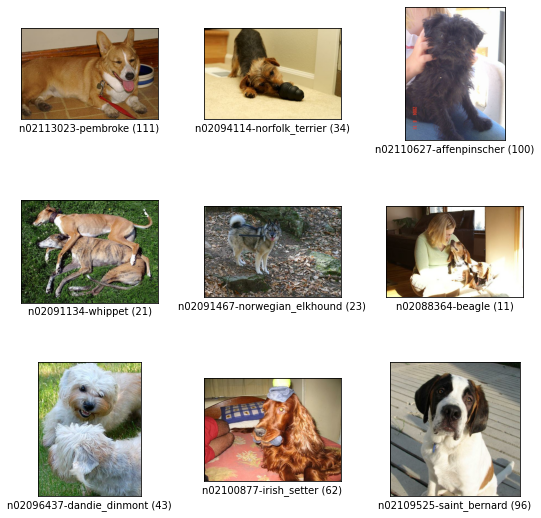

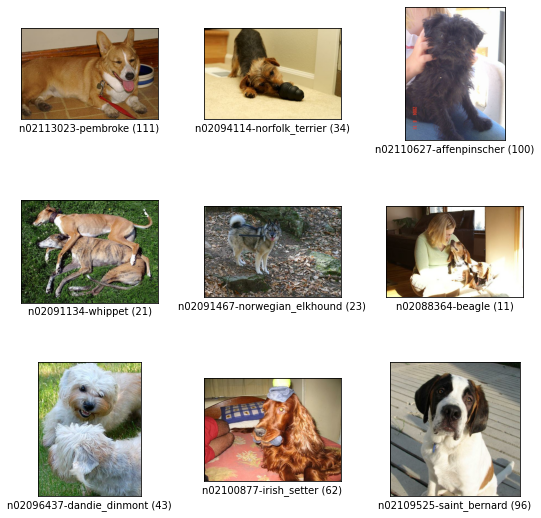

In [4]:
tfds.show_examples(ds_train, ds_info)

**1-5 test 데이터 샘플 확인**

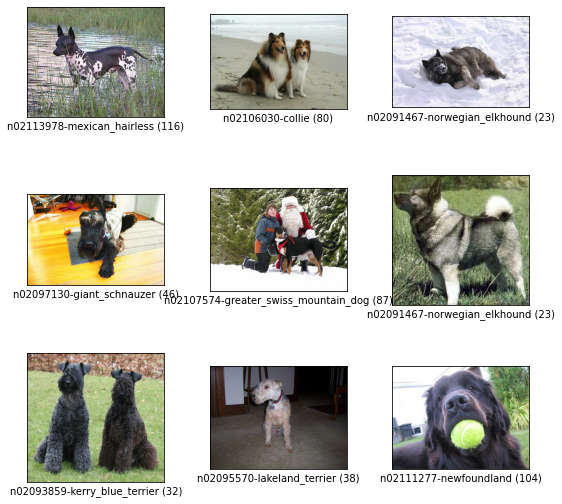

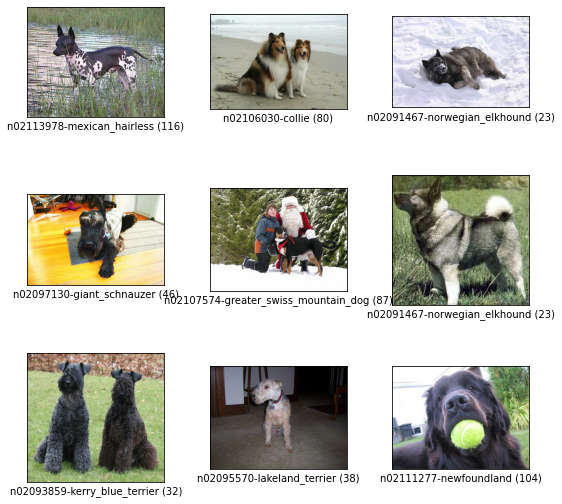

In [5]:
tfds.show_examples(ds_test, ds_info)

**1-6 데이터 메타정보 조회로 features 구성 확인**

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### ■ Step2 CAM 모델 만들기

**2-1 `ResNet50`으로 CAM 모델 구현**

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


**2-2 CAM 모델 확인**

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

**2-3 데이터 전처리**

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


**2-4 모델 컴파일 및 학습**

In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 372s 449ms/step - loss: 3.2232 - accuracy: 0.2760 - val_loss: 3.2723 - val_accuracy: 0.2114
Epoch 2/15
750/750 [==============================] - 347s 462ms/step - loss: 0.9854 - accuracy: 0.7248 - val_loss: 1.1068 - val_accuracy: 0.6782
Epoch 3/15
750/750 [==============================] - 334s 446ms/step - loss: 0.3558 - accuracy: 0.9128 - val_loss: 0.9774 - val_accuracy: 0.7185
Epoch 4/15
750/750 [==============================] - 335s 446ms/step - loss: 0.1070 - accuracy: 0.9847 - val_loss: 0.9520 - val_accuracy: 0.7264
Epoch 5/15
750/750 [==============================] - 335s 446ms/step - loss: 0.0324 - accuracy: 0.9992 - val_loss: 0.9118 - val_accuracy: 0.7414
Epoch 6/15
750/750 [==============================] - 334s 446ms/step - loss: 0.0203 - accuracy: 0.9990 - val_loss: 0.9057 - val_accuracy: 0.7429
Epoch 7/15
750/750 [==============================] - 335s 446ms/step - loss: 0.0132 - accuracy: 0.9993 - val_loss: 0.9307 -

**2-5 학습시킨 가중치 저장**

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


### ■ Step3  CAM 구현

**3-1 메모리 부족 문제 예방을 위해 커널 재시작 및 이전 스텝 코드 일괄 실행**

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


**3-2 개별 이미지 데이터 단위로 CAM 생성을 위한 함수 정의 및 적용**

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


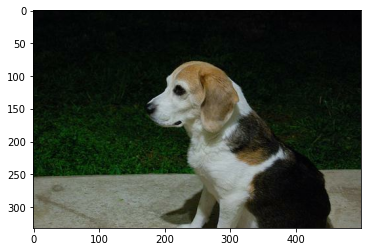

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

**3-3 학습한 CAM 모델 불러오기**

In [4]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

**3-4 CAM 생성 함수 정의 및 적용**

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

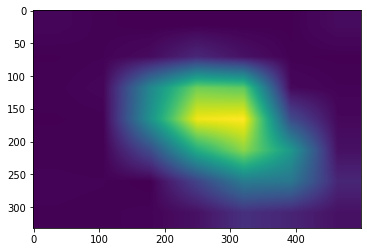

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

**3-5 CAM 이미지를 원본 이미지와 합치는 함수 정의 및 적용**

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

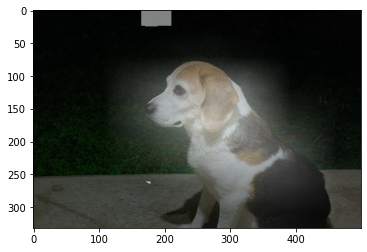

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### ■ Step4 Grad-CAM 구현

**4-1 새로운 이미지 불러오기**

90


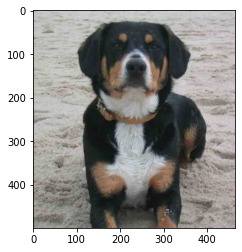

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

**4-2 Grad-CAM 생성 및 원본과 합치기**

In [10]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

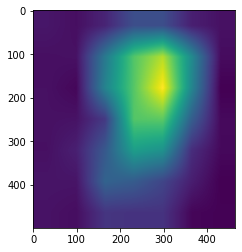

In [14]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

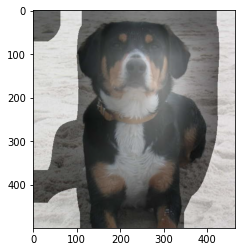

In [18]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

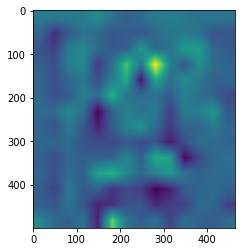

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

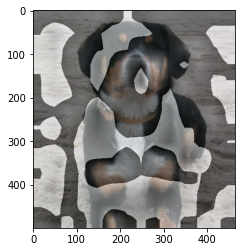

In [21]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

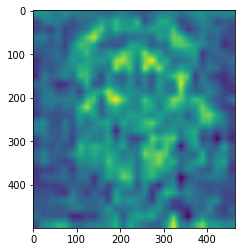

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

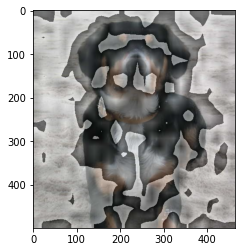

In [23]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### ■ Step5 바운딩 박스 구하기

**5-1 새로운 이미지 불러오기**

84


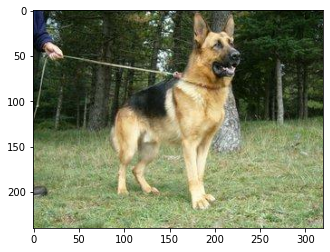

In [35]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

**5-2 CAM 이미지 생성**

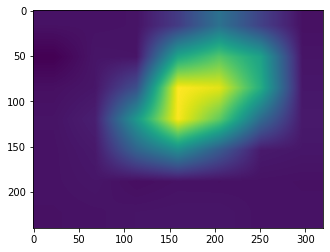

In [36]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

**5-3 바운딩 박스 생성 함수 정의 및 적용**

In [37]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [38]:
rect = get_bbox(cam_image)
rect

array([[ 70,   0],
       [293,   0],
       [293, 184],
       [ 70, 184]])

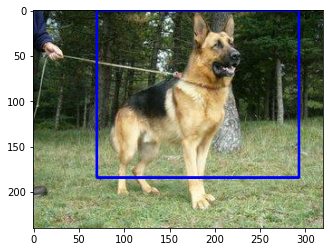

In [39]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

**5-4 Grad-CAM 이미지 생성 및 바운딩 박스 생성**

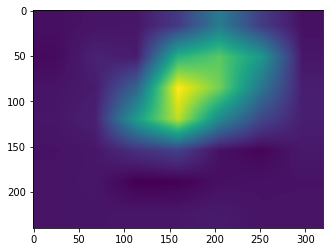

In [40]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [41]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 70,   0],
       [294,   0],
       [294, 170],
       [ 70, 170]])

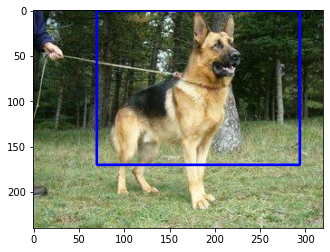

In [42]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### ■ Step6 IoU(Intersection Over Union) 구하기

**6-1 바운딩 박스를 minmax 바운딩 박스 형태로 치환하는 함수 정의 및 적용**

In [43]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [44]:
#CAM 이미지 바운딩박스 minmax로 치환

pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.21875, 0.7666666666666667, 0.915625]

In [45]:
#Grad-CAM 이미지 바운딩박스 minmax로 치환

grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.0, 0.21875, 0.7083333333333334, 0.91875]

**6-2 ground truth bbox 확인**

In [46]:
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

**6-3 IoU 계산 함수 정의 및 적용**

In [47]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [48]:
#CAM 이미지의 bbox와 ground truth bbox의 IoU

get_iou(pred_bbox, item['objects']['bbox'][0])

0.6248938638552024

In [49]:
#Grad-CAM 이미지의 bbox와 ground truth bbox의 IoU

get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.5862068907684437

### ■ Step7 다른 이미지로 한 번 더 확인

80


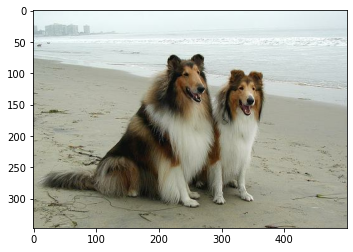

In [77]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

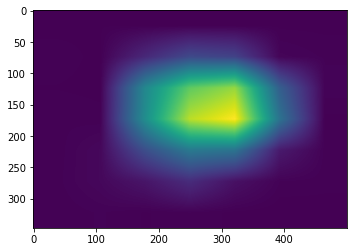

In [78]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

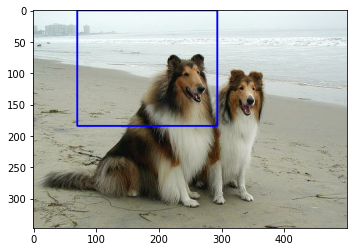

In [79]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

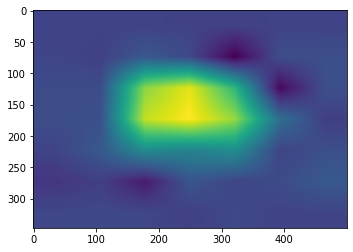

In [80]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

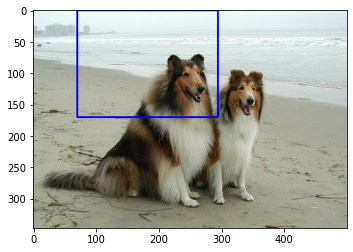

In [81]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [82]:
pred_bbox_iou= get_iou(pred_bbox, item['objects']['bbox'][0])
grad_pred_bbox_iou= get_iou(grad_pred_bbox, item['objects']['bbox'][0])
print(pred_bbox_iou)
print(grad_pred_bbox_iou)

0.2828580771128738
0.260222134976837


### ■ 정리 및 회고

|One dog|CAM|Grad-CAM|
|---|---|---|
|image|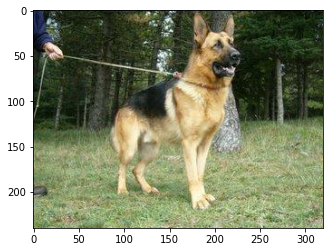|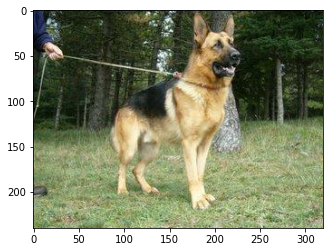|
|class activation map|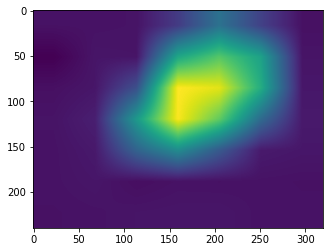|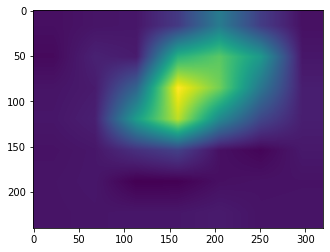|
|bbox|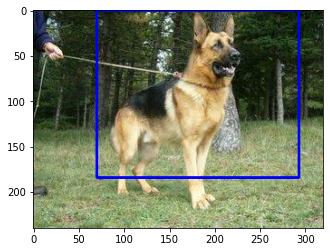|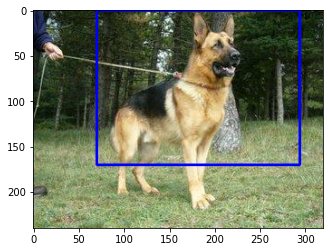|
|IoU|0.6248938638552024|0.5862068907684437|

|tow dogs|CAM|Grad-CAM|
|---|---|---|
|image|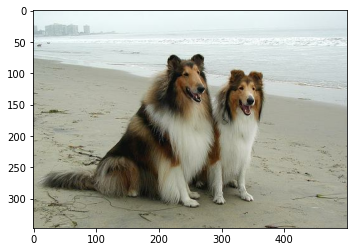|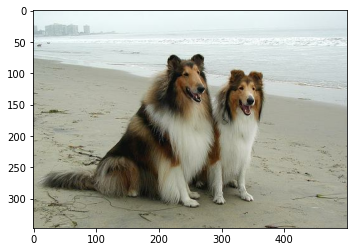|
|class activation map|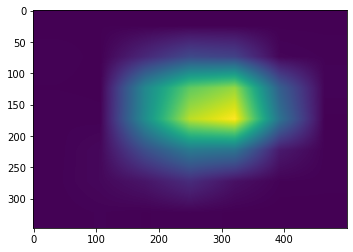|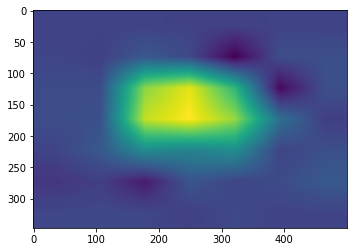|
|bbox|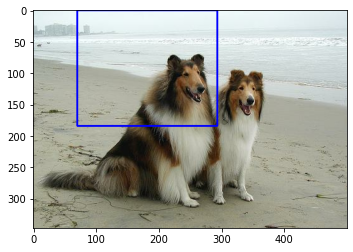|!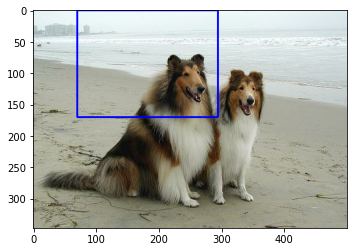|
|IoU|0.2828580771128738|0.260222134976837|

**1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?**

- ResNet50에 GAP(Global Average Pooling)과 DenseLayer를 결합한 CAM 모델의 학습과정이 안정적으로 수렴하였다. 


**2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?**

- CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어졌으며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영하였다.


**3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?**

- CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능을 비교분석해보았다.

- 개 한 마리가 있는 사진과 개 두 마리가 있는 사진을 비교해보았느데, 둘 다 모두 CAM보다는 Grad-CAM의 class activation map이 조금 더 좁은 부분의 특정 위치에 집중한 것을 확인할 수 있었다. 사실 위 예시 사진은 그 차이가 뚜렷하게 보이진 않지만 미세한 집중의 차이가 있다. 한편, IoU의 경우 두 사진 모두 CAM의 성능이 더 약간 더 높게 나왔다. 개 두 마리 사진의 경우 IoU가 CAM과 Grad-CAM 모두 낮게 나왔는데, 정답 bbox는 두 마리의 개 모두를 바운딩 해서 그런 것 같다.

**이번 프로젝트를 통해 모델이 이미지의 어느 부분에 집중하며 특징을 추출해 내는지 알 수 있었다. 마치 사람이 시각으로 전경과 배경을 분리하여 객체를 인식하는 것과 큰 차이가 없는 것 같기도 해서 흥미로웠다.**